N-Beats implementation on Weekly Sales





In [48]:
pip install mxnet-cu102

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
pip install "gluonts[mxnet]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# import all necessary libraries
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.model.n_beats import NBEATSEstimator
from gluonts.mx.trainer import Trainer
import numpy as np
import matplotlib as mb
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator

In [51]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv

--2023-04-05 04:08:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317399 (310K) [application/x-httpd-php]
Saving to: ‘Sales_Transactions_Dataset_Weekly.csv.2’

Sales_Transactions_ 100%[===================>] 309.96K  --.-KB/s    in 0.05s   

2023-04-05 04:08:01 (6.40 MB/s) - ‘Sales_Transactions_Dataset_Weekly.csv.2’ saved [317399/317399]



In [52]:
# Import the data
Sales_Data=pd.read_csv("/content/Sales_Transactions_Dataset_Weekly.csv")

In [53]:
Sales_Data.shape

(811, 107)

In [54]:
Sales_Data

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,...,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,...,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,...,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00


In [55]:
# remove extra columns
Sales_Data=Sales_Data.iloc[:,0:53]

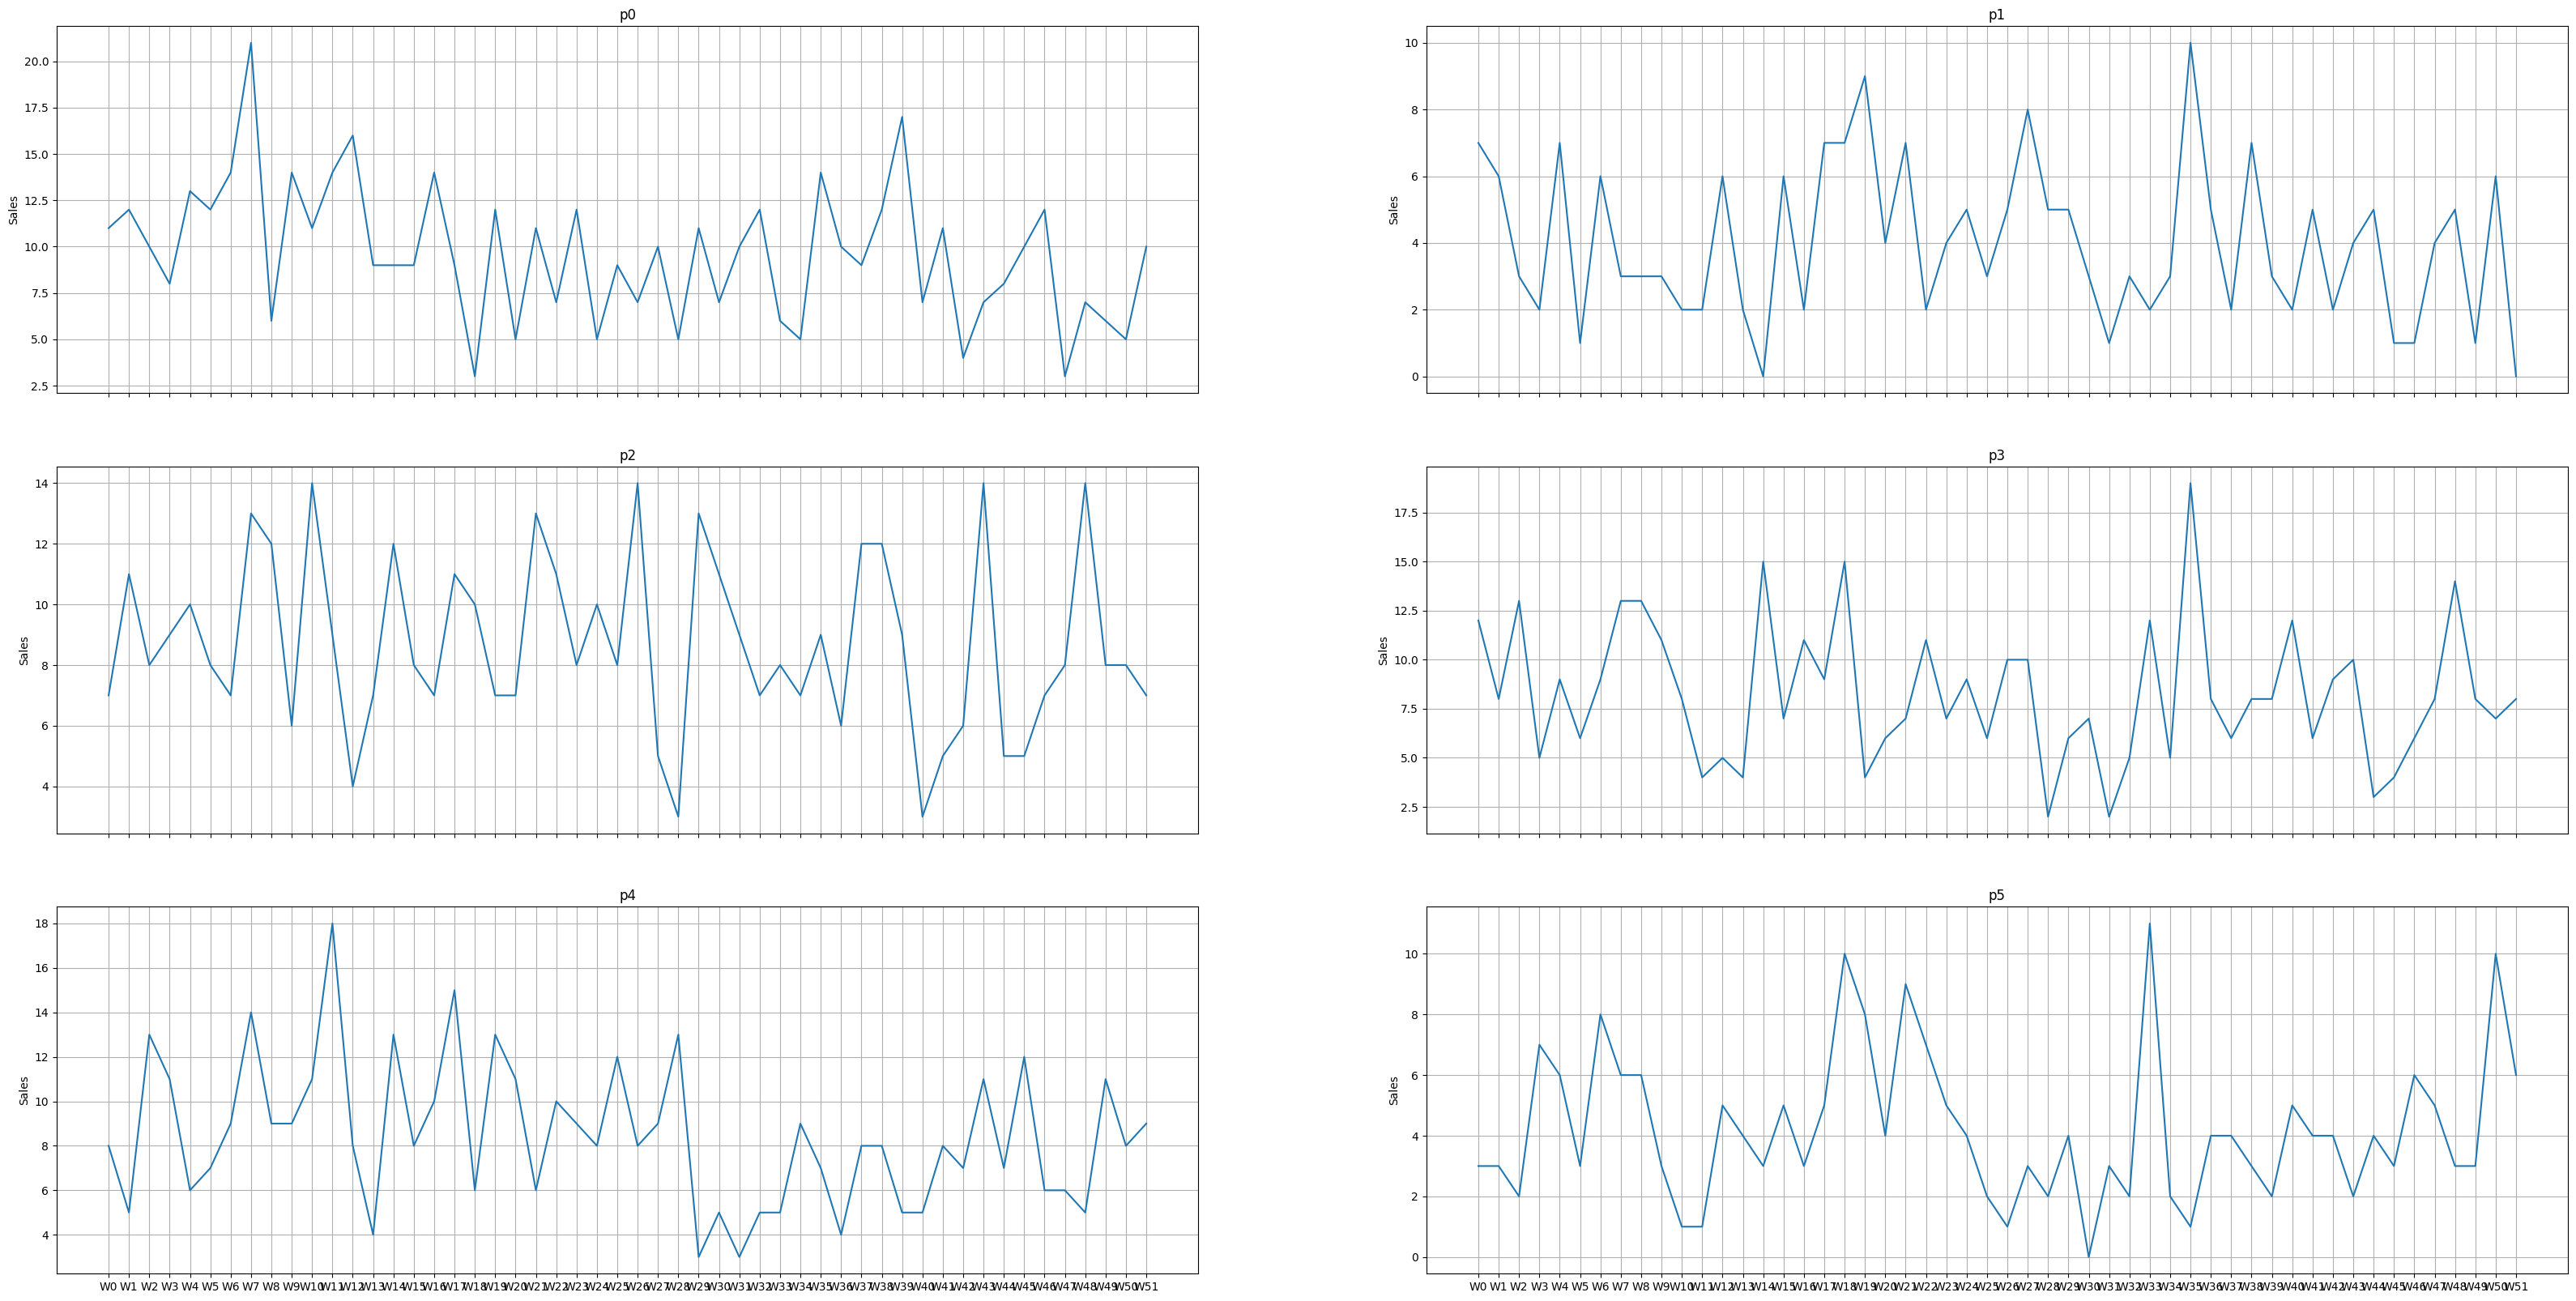

In [56]:
#plots of sample data for a custom range of prodct's time series
plt.rcParams["axes.grid"] = True
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(40,20),sharex=True)

axes_array=ax.ravel()
for i in range(0,6):
    axes_array[i].plot(Sales_Data.iloc[i,1:])
    axes_array[i].set(title=f'p{i}' , ylabel="Sales")
    axes_array[i].grid(which='minor',axis='x')

In [57]:
Sales_Data=Sales_Data.T.reset_index(drop=True).T

In [58]:
Sales_Data

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0


In [59]:
# In order to utilise house hold id's as feature static variable in GluonTS theses column was converted to codes for categorical feature processing.
Product_codes=Sales_Data.iloc[:,0].astype('category').cat.codes.values
Product_codes

array([  0, 111, 222, 331, 442, 553, 662, 769, 800,   1,  12,  23,  34,
        45,  56,  67,  78,  89, 100, 112, 123, 134, 145, 156, 167, 178,
       189, 200, 211, 223, 234, 245, 256, 267, 278, 288, 299, 310, 320,
       332, 343, 354, 365, 376, 387, 398, 409, 420, 431, 443, 454, 465,
       476, 487, 498, 509, 520, 531, 542, 554, 565, 576, 587, 598, 607,
       618, 629, 640, 651, 663, 673, 683, 692, 703, 714, 725, 736, 747,
       758, 770, 781, 792, 793, 794, 795, 796, 797, 798, 799, 801, 802,
       803, 804, 805, 806, 807, 808, 809, 810,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  90,  9

In [60]:
#split the data feame into test and train sets
Sales_train=Sales_Data.iloc[:,1:42].values
Sales_test=Sales_Data.iloc[:,42:].values

In [61]:
Sales_train.shape

(811, 41)

In [62]:
Sales_test.shape

(811, 11)

In [63]:
freq="W"
start_train = pd.Timestamp("2014-01-01", freq=freq)
start_test = pd.Timestamp("2014-10-08", freq=freq)
prediction_lentgh=7

<ipython-input-63-09e0427a69b6>:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp("2014-01-01", freq=freq)
<ipython-input-63-09e0427a69b6>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp("2014-10-08", freq=freq)


In [64]:
estimator = NBEATSEstimator(
                            freq=freq,
                            stack_types=["G"],
                            prediction_length=7,
                            context_length=7,
                            loss_function='MAPE',
                            scale=True,
                            trainer=Trainer(
                            epochs=30))

In [65]:
# Convert the data into gluonts list dataset form to input the model
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(Sales_train,
                             Product_codes.reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(Sales_test,
                            Product_codes.reshape(-1,1))
], freq=freq)

In [77]:
# train the estimator
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:21<00:00,  2.29it/s, epoch=30/30, avg_epoch_loss=3.97]


In [67]:
# Generation of predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor 
)

In [68]:
# Conversion of predictions to a list
print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(Sales_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(Sales_test)))

Obtaining time series conditioning values ...


  0%|          | 0/811 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/811 [00:00<?, ?it/s]

In [ ]:
forecasts

In [ ]:
# plot the predictions with probabilistic ranges ( provided in the official documentation of gluonTS )
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [71]:
#Utilise default library from gluonTS for evaluating the perfromance of the model
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss),iter(forecasts),  num_series=len(Sales_test))

Running evaluation: 100%|██████████| 811/811 [00:00<00:00, 7102.03it/s]
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [ ]:
type(item_metrics)

In [73]:
agg_metrics['ND']

0.38838802434346886

In [74]:
item_metrics['RMSE']=np.sqrt(item_metrics['MSE'])
# Print the NRMSE for each time series
item_metrics['NRMSE']=item_metrics['RMSE']/item_metrics['abs_target_mean']
item_metrics.to_csv('NBeats_Sales_Results_Final.csv')

In [75]:
# number of time series with less than 0.5 nrmse
item_metrics[item_metrics['NRMSE']<0.5].count()

item_id                0
forecast_start       249
MSE                  249
abs_error            249
abs_target_sum       249
abs_target_mean      249
seasonal_error       249
MASE                 249
MAPE                 249
sMAPE                249
ND                   249
MSIS                 249
QuantileLoss[0.1]    249
Coverage[0.1]        249
QuantileLoss[0.2]    249
Coverage[0.2]        249
QuantileLoss[0.3]    249
Coverage[0.3]        249
QuantileLoss[0.4]    249
Coverage[0.4]        249
QuantileLoss[0.5]    249
Coverage[0.5]        249
QuantileLoss[0.6]    249
Coverage[0.6]        249
QuantileLoss[0.7]    249
Coverage[0.7]        249
QuantileLoss[0.8]    249
Coverage[0.8]        249
QuantileLoss[0.9]    249
Coverage[0.9]        249
RMSE                 249
NRMSE                249
dtype: int64

In [76]:
# number of time series with less than 0.4 nrmse
item_metrics[item_metrics['NRMSE']>0.5].count()

item_id                0
forecast_start       562
MSE                  562
abs_error            562
abs_target_sum       562
abs_target_mean      562
seasonal_error       562
MASE                 562
MAPE                 516
sMAPE                562
ND                   562
MSIS                 562
QuantileLoss[0.1]    562
Coverage[0.1]        562
QuantileLoss[0.2]    562
Coverage[0.2]        562
QuantileLoss[0.3]    562
Coverage[0.3]        562
QuantileLoss[0.4]    562
Coverage[0.4]        562
QuantileLoss[0.5]    562
Coverage[0.5]        562
QuantileLoss[0.6]    562
Coverage[0.6]        562
QuantileLoss[0.7]    562
Coverage[0.7]        562
QuantileLoss[0.8]    562
Coverage[0.8]        562
QuantileLoss[0.9]    562
Coverage[0.9]        562
RMSE                 562
NRMSE                562
dtype: int64